<a href="https://colab.research.google.com/github/RDMerlo/MerloChat/blob/main/train.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn

class NeuralNet(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNet, self).__init__()
        self.l1 = nn.Linear(input_size, hidden_size)
        self.act1 = torch.nn.Tanh()
        self.l2 = nn.Linear(hidden_size, hidden_size)
        self.act2 = torch.nn.Tanh()
        self.l3 = nn.Linear(hidden_size, num_classes)
    
    def forward(self, x):
        x = self.l1(x)
        x = self.act1(x)
        x = self.l2(x)
        x = self.act2(x)
        x = self.l3(x)
        return x

In [ ]:
!pip install pymorphy2 #скачивание библиотеки
!pip install -U pymorphy2-dicts-ru #скачивание русского словаря

import numpy as np
import nltk
nltk.download('punkt') #для работы токенизации
from nltk.tokenize import word_tokenize
import pymorphy2

import json

import math

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 3.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 29.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13707 sha256=cdc2feb1267f7182f56f73d2778454c0c67b5667ae125b1b32d8045d1d1cb246
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
def tokenize_lemmatize(sentence, bool_ignore_word = True):
    arToken = word_tokenize(sentence, language="russian")
    
    with open('/content/drive/MyDrive/ChatBotGitHub/stop_symbols.json', 'r') as f:
      ignore_symbols = json.load(f)
    arToken = [w for w in arToken if w not in ignore_symbols]
    
    morph = pymorphy2.MorphAnalyzer()
    arToken = [morph.parse(token)[0].normal_form for token in arToken]

    if (bool_ignore_word):
      with open('/content/drive/MyDrive/ChatBotGitHub/stop_words2.json', 'r') as f:
        stop_words = json.load(f)
      arToken = [w for w in arToken if w not in stop_words]

    return arToken

def words_processing(intents, bool_ignore_word):
  all_words = []
  tags = []
  xy = []
  # проходимся по сущностям
  for intent in intents['intents']:
    tag = intent['tag'] # сохраняем тэг
    tags.append(tag)
    # проходимся по паттернам
    for pattern in intent['patterns']:
      w = tokenize_lemmatize(pattern, bool_ignore_word)
      all_words.extend(w)
      xy.append((w, tag))
  # удаляем дупликаты и сортируем
  all_words = sorted(set(all_words))
  tags = sorted(set(tags))
  return all_words, tags, xy

def bag_of_words(pattern_sentence, all_words):
    bag = np.zeros(len(all_words), dtype=np.float32)
    for idx, w in enumerate(all_words):
        if w in pattern_sentence: 
            bag[idx] = 1
    return bag

def tf(all_words, pattern_sentence):
  tf = np.zeros(len(all_words), dtype=np.float32)
  #проходимся по каждому слову из словаря и смотрим, есть ли он в документе
  for idx, w in enumerate(all_words):
    if w in pattern_sentence: 
      tf[idx] += 1/len(pattern_sentence)
  
  return tf

def idf(all_words, xy):
  #количество документов в котором встречается слово
  count_pattern = np.zeros(len(all_words), dtype=np.float32)

  for idx, w in enumerate(all_words):
    # #проходимся по каждому документу
    for (pattern_sentence, tag) in xy:
      if w in pattern_sentence: 
        count_pattern[idx] += 1

  idf = [math.log(len(xy)/count_pattern) for count_pattern in count_pattern]
  return idf

In [ ]:
text = "Здравствуйте, что вы умеете?"
print(text)

all_words = word_tokenize(text, language="russian")
print(all_words)

with open('/content/drive/MyDrive/ChatBotGitHub/stop_symbols.json', 'r') as f:
    ignore_symbols = json.load(f)
all_words = [w for w in all_words if w not in ignore_symbols]

print(all_words)

morph = pymorphy2.MorphAnalyzer()
all_words = [morph.parse(word)[0].normal_form for word in all_words]

print(all_words)

with open('/content/drive/MyDrive/ChatBotGitHub/stop_words2.json', 'r') as f:
    stop_words = json.load(f)
all_words = [w for w in all_words if w not in stop_words]

print(all_words)


Здравствуйте, что вы умеете?
['Здравствуйте', ',', 'что', 'вы', 'умеете', '?']
['Здравствуйте', 'что', 'вы', 'умеете']
['здравствуйте', 'что', 'вы', 'уметь']
['здравствуйте', 'уметь']


In [ ]:
import numpy as np
import random
import json

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

nltk.download('punkt')

with open('/content/drive/MyDrive/ChatBotGitHub/uunit_dataset_nomat.json', 'r') as f:
  intents = json.load(f)

with open('/content/drive/MyDrive/ChatBotGitHub/uunit_dataset_test.json', 'r') as f:
  test_intents = json.load(f)

all_words, tags, xy = words_processing(intents, True)
test_all_words, _, test_xy = words_processing(intents, False)

print(len(xy), "паттерны", xy)
print(len(tags), "тэги:", tags)
print(len(all_words), "уникальные слова:", all_words)




[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


920 паттерны [(['привет'], 'приветствие'), (['здравствуйте'], 'приветствие'), (['добрый', 'вечер'], 'приветствие'), (['добрый', 'утро'], 'приветствие'), (['добрый', 'день'], 'приветствие'), (['привет', 'помочь'], 'приветствие'), (['здравствуйте', 'помочь'], 'приветствие'), (['вопрос'], 'приветствие'), (['привет', 'вопрос'], 'приветствие'), (['привет', 'вопрос', 'помочь'], 'приветствие'), (['здравствуйте', 'вопрос'], 'приветствие'), (['здравствуйте', 'вопрос', 'помочь'], 'приветствие'), (['эй'], 'приветствие'), (['нужный', 'помощь'], 'приветствие'), (['предоставить', 'некоторый', 'информация'], 'приветствие'), (['здравствуйте', 'нужный', 'помощь'], 'приветствие'), (['здравствуйте', 'предоставить', 'некоторый', 'информация'], 'приветствие'), (['привет', 'нужный', 'помощь'], 'приветствие'), (['привет', 'предоставить', 'некоторый', 'информация'], 'приветствие'), (['искать', 'некоторый', 'руководство', 'помочь'], 'приветствие'), (['помочь'], 'приветствие'), (['хотеть', 'задать', 'вопрос'], 

In [ ]:
with open('/content/drive/MyDrive/ChatBotGitHub/primer.json', 'r') as f:
  intents_prim = json.load(f)

all_words_prim, tags_prim, xy_prim = words_processing(intents_prim, False)

print(all_words_prim)



print("\n\n")
for x in X:
  print(x)

['ель', 'кот', 'на', 'пенить', 'пёс', 'сесть']
[0.6931471805599453, 0.6931471805599453, 0.0, 0.6931471805599453, 0.6931471805599453, 0.0]
[0.   0.   0.25 0.25 0.25 0.25]
[0.25 0.25 0.25 0.   0.   0.25]



[0.        0.        0.        0.1732868 0.1732868 0.       ]
[0.1732868 0.1732868 0.        0.        0.        0.       ]


In [ ]:
# all_words.reverse()
print("слов в словаре:", len(all_words))
print("[", end=" ")
for i, a in enumerate(all_words):
  if (i < 5 or i > 447):
    print(a, end=" ")
  if (i==5):
    print("...", end=" ")
print("]", end="")
# print(len(all_words), "слов в словаре:", all_words)

слов в словаре: 452
[ ai/мл it-технология автомат автор адрес ... электронный являться язык японский ]

In [ ]:
dict_xy = {}

for (pattern_sentence, tag) in xy:
  if (tag == "оскорбление"):
    continue
  if (tag in dict_xy):
    dict_xy[tag] += 1
  else:
    dict_xy[tag] = 1

print(dict_xy)

{'приветствие': 38, 'прощание': 32, 'автор_чата': 30, 'благодарность': 31, 'чистота_вуза': 6, 'имя_бота': 22, 'перерывы': 29, 'график_работы': 21, 'библиотека': 21, 'общая_информация': 25, 'факультет': 19, 'направления_специальности': 56, 'дополнительные_курсы': 23, 'универститет_поступление': 80, 'оплата_за_обучение': 20, 'оплата_за_общежитие': 17, 'общежитие': 21, 'местоположение_университета': 16, 'учебная_программа': 24, 'столовая': 48, 'ректор': 10, 'декан_фмиит': 40, 'расписание': 20, 'расписание_фмиит': 98, 'допуск_вуз': 28, 'стипендия': 28, 'униформа': 29, 'функционал': 36, 'местоположение_фмиит': 52}


In [ ]:
dict_xy[max(dict_xy, key=dict_xy.get)]
max(dict_xy, key=dict_xy.get)

'расписание_фмиит'

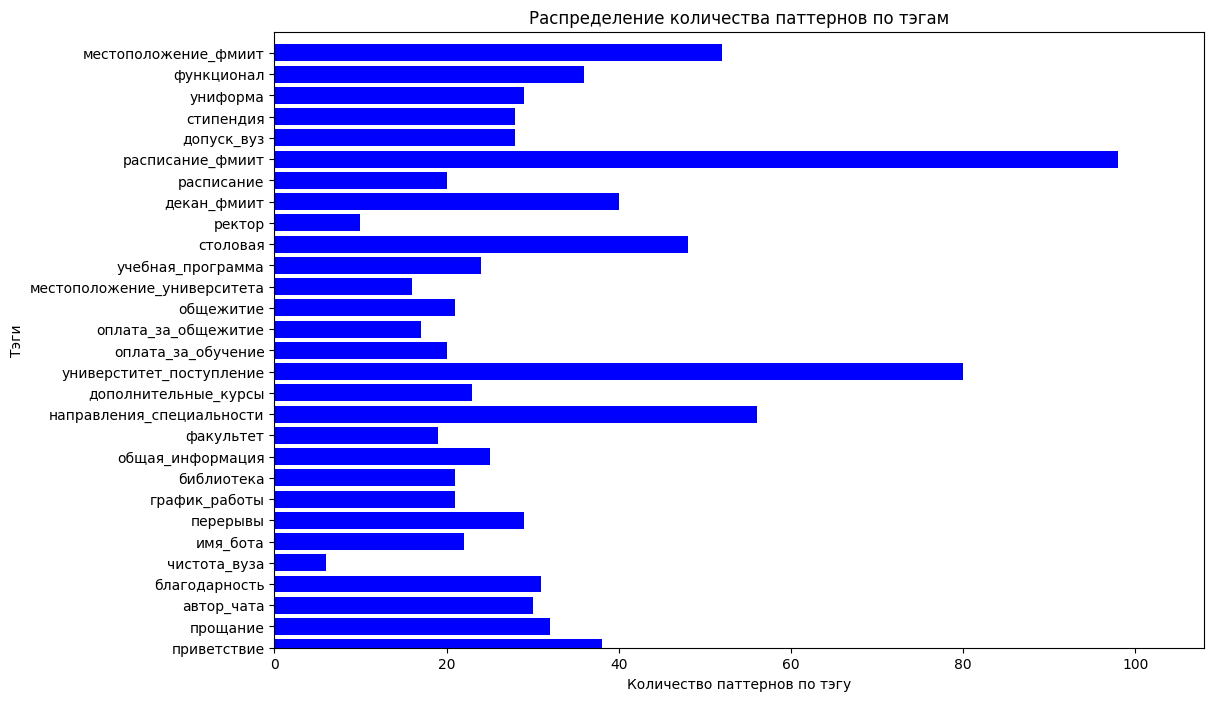

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 8))
plt.barh(list(dict_xy.keys()), dict_xy.values(), color='b')
plt.title('Распределение количества паттернов по тэгам')
plt.xlabel('Количество паттернов по тэгу')
plt.ylabel('Тэги')
plt.xlim(0, dict_xy[max(dict_xy, key=dict_xy.get)]+10)
plt.ylim(0, len(tags))
plt.show()

In [ ]:
class ChatDataset(Dataset):
    def __init__(self, X, Y):
        self.n_samples = len(X)
        self.x_data = X
        self.y_data = Y
    # доступ к набору данным по индексу
    def __getitem__(self, index):
        return self.x_data[index], self.y_data[index]
    # количество выборок
    def __len__(self):
        return self.n_samples

def createDataTraining(all_words, xy):
  X = []
  y = []
  for (pattern_sentence, tag) in xy:
      bag = bag_of_words(pattern_sentence, all_words)
      tag_index = tags.index(tag)
      X.append(bag)
      y.append(tag_index)
  X = np.array(X)
  y = np.array(y)
  return X, y

def createDataTraining_tfidf(all_words, xy):
  X = []
  y = []
  vectorIDF = idf(all_words, xy)
  X = []
  for (pattern_sentence, tag) in xy:
    vectorTF = tf(all_words, pattern_sentence)
    X.append(vectorTF * vectorIDF)
    tag_index = tags.index(tag)
    y.append(tag_index)
  X = np.array(X)
  y = np.array(y)
  return X, y

def printXY(X, Y, a = 5):
  for idx, x in enumerate(X):
    for i, b in enumerate(x):
      if (i < a or i > (len(x)-5)):
        print(b, end=" ")
      if (i == a):
        print("...", end=" ")
    print("| ", Y[idx])
    
X_train, y_train = createDataTraining(all_words, xy)
X_test, y_test = createDataTraining(test_all_words, test_xy)

# print(len(X_test))

printXY(X_train, y_train)

dataset = ChatDataset(X_train, y_train)
test_dataset = ChatDataset(X_test, y_test)

0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 |  16
0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.

In [ ]:
X_train
# len(X_train)
# len(y_train)

array([[0., 0.],
       [1., 0.],
       [0., 0.],
       ...,
       [0., 0.],
       [0., 0.],
       [0., 0.]], dtype=float32)

In [ ]:
#tfidf

random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def testAccuracy(model, train_loader):
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in train_loader:
            words, labels = data
            words = words.to(torch.float32)
            outputs = model.forward(words)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    accuracy = (100 * accuracy / total)
    return(accuracy)

# Параметры
num_epochs = 3250
batch_size = 8 #8
hidden_size = 4 #8

input_size = len(X_train[0])
output_size = len(tags)

train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size, #батчи
                          shuffle=True, #перетасовка
                          num_workers=0) #многопоточность

# test_loader = DataLoader(dataset=test_dataset,
#                           batch_size=batch_size,
#                           shuffle=True,
#                           num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

test_accuracy_history = []
test_loss_history = []

# Функция потерь и оптимизация
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=3.0e-4)

# Тренировка модели
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        optimizer.zero_grad()
        words = words.to(torch.float32)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 50 == 0:
        accuracy = testAccuracy(model, train_loader)
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f} Loss: {loss.item():.4f}')

print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

from datetime import datetime
current_datetime = datetime.now()

FILE = f"/content/drive/MyDrive/ChatBotGitHub/dataset-{current_datetime}.pth"
torch.save(data, FILE)

print(f'Датасет сохранён — {FILE}')



Epoch [50/3250], Accuracy: 56.6304 Loss: 1.8632
Epoch [100/3250], Accuracy: 67.7174 Loss: 1.4067
Epoch [150/3250], Accuracy: 70.7609 Loss: 0.7991
Epoch [200/3250], Accuracy: 73.4783 Loss: 0.6179
Epoch [250/3250], Accuracy: 80.2174 Loss: 0.6418
Epoch [300/3250], Accuracy: 86.0870 Loss: 0.6999
Epoch [350/3250], Accuracy: 95.6522 Loss: 0.5334
Epoch [400/3250], Accuracy: 95.5435 Loss: 0.3135
Epoch [450/3250], Accuracy: 95.7609 Loss: 0.2949
Epoch [500/3250], Accuracy: 96.1957 Loss: 0.1753
Epoch [550/3250], Accuracy: 96.7391 Loss: 0.3410
Epoch [600/3250], Accuracy: 97.5000 Loss: 0.3087
Epoch [650/3250], Accuracy: 98.1522 Loss: 0.4070
Epoch [700/3250], Accuracy: 98.1522 Loss: 0.3059
Epoch [750/3250], Accuracy: 98.1522 Loss: 0.1431
Epoch [800/3250], Accuracy: 98.1522 Loss: 0.0892
Epoch [850/3250], Accuracy: 97.9348 Loss: 0.2049
Epoch [900/3250], Accuracy: 98.2609 Loss: 0.2596
Epoch [950/3250], Accuracy: 98.0435 Loss: 0.0817
Epoch [1000/3250], Accuracy: 98.2609 Loss: 0.0779
Epoch [1050/3250], A

In [ ]:
random.seed(0)
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True

def testAccuracy(model, train_loader):
    model.eval()
    accuracy = 0.0
    total = 0.0
    with torch.no_grad():
        for data in train_loader:
            words, labels = data
            outputs = model(words)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            accuracy += (predicted == labels).sum().item()
    accuracy = (100 * accuracy / total)
    return(accuracy)

# Параметры
num_epochs = 2550
batch_size = 64 #8
hidden_size = 4 #8

input_size = len(X_train[0])
output_size = len(tags)

train_loader = DataLoader(dataset=dataset,
                          batch_size=batch_size, #батчи
                          shuffle=True, #перетасовка
                          num_workers=0) #многопоточность

test_loader = DataLoader(dataset=test_dataset,
                          batch_size=batch_size,
                          shuffle=True,
                          num_workers=0)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

model = NeuralNet(input_size, hidden_size, output_size).to(device)

test_accuracy_history = []
test_loss_history = []

# Функция потерь и оптимизация
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-3)

# Тренировка модели
for epoch in range(num_epochs):
    for (words, labels) in train_loader:
        optimizer.zero_grad()
        words = words.to(device)
        labels = labels.to(dtype=torch.long).to(device)
        outputs = model(words)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

    if (epoch+1) % 50 == 0:
        accuracy = testAccuracy(model, train_loader)
        test_accuracy_history.append(accuracy)
        test_loss_history.append(loss.item())
        print(f'Epoch [{epoch+1}/{num_epochs}], Accuracy: {accuracy:.4f} Loss: {loss.item():.4f}')

print(f'final loss: {loss.item():.4f}')

data = {
"model_state": model.state_dict(),
"input_size": input_size,
"hidden_size": hidden_size,
"output_size": output_size,
"all_words": all_words,
"tags": tags
}

from datetime import datetime
current_datetime = datetime.now()

FILE = f"/content/drive/MyDrive/ChatBotGitHub/dataset-{current_datetime}.pth"
torch.save(data, FILE)

print(f'Датасет сохранён — {FILE}')



Epoch [50/2550], Accuracy: 41.9565 Loss: 2.2700
Epoch [100/2550], Accuracy: 56.8478 Loss: 1.4335
Epoch [150/2550], Accuracy: 73.5870 Loss: 1.0324
Epoch [200/2550], Accuracy: 74.1304 Loss: 1.0007
Epoch [250/2550], Accuracy: 79.2391 Loss: 0.7955
Epoch [300/2550], Accuracy: 83.1522 Loss: 0.7179
Epoch [350/2550], Accuracy: 86.5217 Loss: 0.6000
Epoch [400/2550], Accuracy: 87.6087 Loss: 0.7528
Epoch [450/2550], Accuracy: 88.1522 Loss: 0.4212
Epoch [500/2550], Accuracy: 89.5652 Loss: 0.4809
Epoch [550/2550], Accuracy: 89.5652 Loss: 0.5419
Epoch [600/2550], Accuracy: 91.7391 Loss: 0.2776
Epoch [650/2550], Accuracy: 92.2826 Loss: 0.4514
Epoch [700/2550], Accuracy: 93.0435 Loss: 0.3880
Epoch [750/2550], Accuracy: 96.8478 Loss: 0.3388
Epoch [800/2550], Accuracy: 97.3913 Loss: 0.2608
Epoch [850/2550], Accuracy: 97.5000 Loss: 0.3507
Epoch [900/2550], Accuracy: 97.5000 Loss: 0.2281
Epoch [950/2550], Accuracy: 97.5000 Loss: 0.2302
Epoch [1000/2550], Accuracy: 97.5000 Loss: 0.1895
Epoch [1050/2550], A

In [ ]:
from datetime import datetime
current_datetime = datetime.now()

FILE = f"/content/drive/MyDrive/ChatBotGitHub/dataset-{current_datetime}.pth"
torch.save(data, FILE)

print(f'training complete. file saved to {FILE}')

training complete. file saved to /content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-09 21:36:19.725145.pth


Text(0, 0.5, 'Loss Function Value')

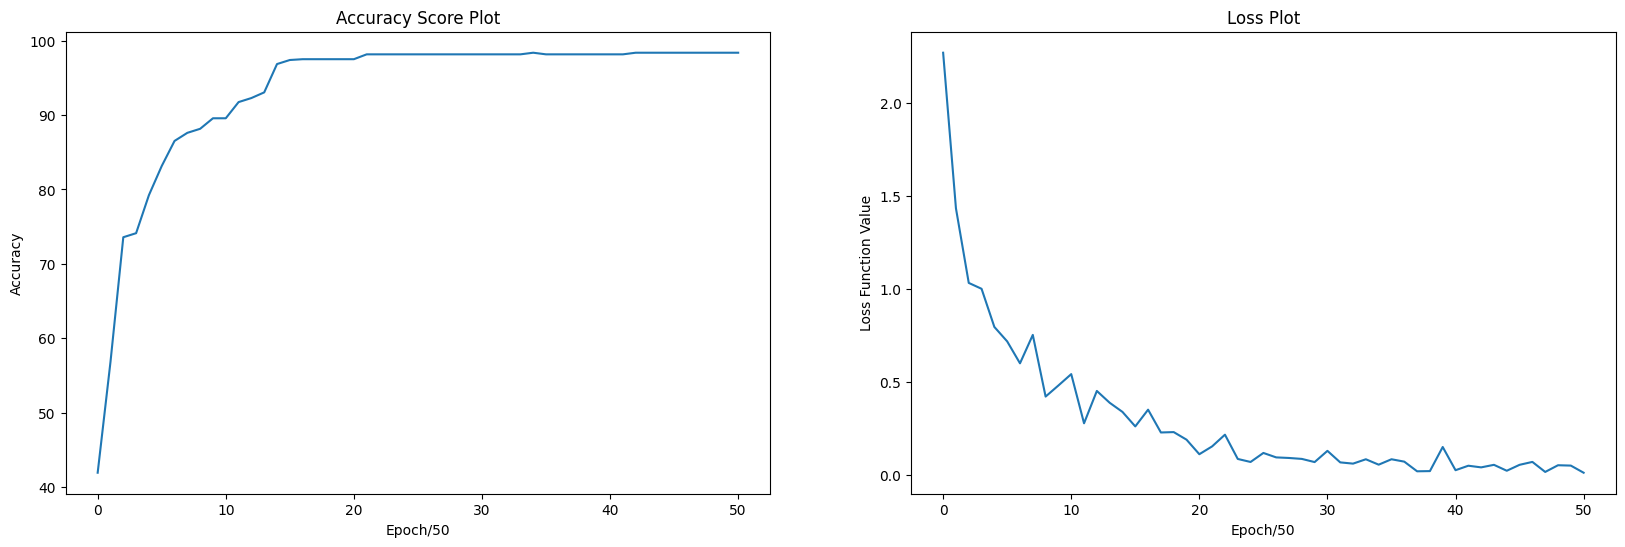

In [ ]:
import matplotlib.pyplot as plt
y_p = model.forward(words)

f, ax = plt.subplots(1, 2, figsize=(20, 6))
ax[0].plot(test_accuracy_history)
ax[0].set_title('Accuracy Score Plot')
ax[0].set_xlabel('Epoch/50')
ax[0].set_ylabel('Accuracy')
ax[1].plot(test_loss_history);
ax[1].set_title('Loss Plot')
ax[1].set_xlabel('Epoch/50')
ax[1].set_ylabel('Loss Function Value')

In [ ]:
import random
import json

import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

with open('/content/drive/MyDrive/ChatBotGitHub/uunit_dataset_nomat.json', 'r') as f:
  intents = json.load(f)

# FILE = "/content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-10 15:42:21.661505.pth" старые
# FILE = "/content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-13 11:42:35.888773.pth" старые
# FILE = "/content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-13 14:26:37.026691.pth" старые

FILE = "/content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-15 12:16:25.971656.pth"

# FILE = "/content/drive/MyDrive/ChatBotGitHub/dataset-2023-05-15 21:19:02.819219.pth" tfidf


data = torch.load(FILE)

input_size = data["input_size"]
hidden_size = data["hidden_size"]
output_size = data["output_size"]
all_words = data['all_words']
tags = data['tags']
model_state = data["model_state"]

model = NeuralNet(input_size, hidden_size, output_size).to(device)
model.load_state_dict(model_state)
model.eval()

bot_name = "Павел"
print("Введите quit чтобы выйти")
while True:
    # sentence = "do you use credit cards?"
    sentence = input("Вы: ")
    if sentence == "quit":
        break

    sentence = tokenize_lemmatize(sentence)
    X = bag_of_words(sentence, all_words)
    X = X.reshape(1, X.shape[0])
    X = torch.from_numpy(X).to(device)

    output = model(X)
    _, predicted = torch.max(output, dim=1)

    # print(predicted)

    tag = tags[predicted.item()]

    probs = torch.softmax(output, dim=1)
    prob = probs[0][predicted.item()]
    if prob.item() > 0.50: 
        for intent in intents['intents']:
            if tag == intent["tag"]:
                print("Тэг: ", intent["tag"])
                print(f"{bot_name}: {random.choice(intent['responses'])}")
                if tag == "до свидания":
                    break
    else:
        print(f"{bot_name}: Извините, не понял вопроса, попробуйте переформулировать вопрос.")

Введите quit чтобы выйти
Вы: где находится библиотека?
Тэг:  библиотека
Павел: В будни библиотека работает по графику:<br>понедельник–пятница: 9:00–18:00<br>в субботу: 9:00–17:00<br>выходной: воскресенье<br>Третья пятница каждого месяца - санитарный день.<br>В универститете присутствуют читальные залы и электронная библиотека — <a href="https://elib.bashedu.ru/" target="_blank" title="Электронно-библиотечная система УУНиТ">"Электронно-библиотечная система УУНиТ"</a><br>Подробнее смотрите на следующих сайтах:<br><a href="https://uust.ru/library/" target="_blank">https://uust.ru/library/</a><br><a href="http://lib.bashedu.ru/" target="_blank">http://lib.bashedu.ru/</a>
Вы: расположение библиотеки
Тэг:  библиотека
Павел: В будни библиотека работает по графику:<br>понедельник–пятница: 9:00–18:00<br>в субботу: 9:00–17:00<br>выходной: воскресенье<br>Третья пятница каждого месяца - санитарный день.<br>В универститете присутствуют читальные залы и электронная библиотека — <a href="https://elib

KeyboardInterrupt: ignored

In [ ]:
with open('/content/drive/MyDrive/ChatBotGitHub/DictionaryRussianWords.txt', 'r') as f:
  rus_dict_word = f.readlines()
len(rus_dict_word)

1532629

In [ ]:
rus_dict_word[100]

'абазинца\n'

In [ ]:

text = "Здравствуйте! Я yfkfykfyk овевоеоевове прэвет хотел бы заказать у вас веб сайт и т.п. и т.д..."
text = "В украинском Николаеве произошли три взрыва, об этом сообщил в Telegram-канале глава областной администрации Виталий Ким."

text = "Обратите внимание на библиотеку JamSpell. Написана изначально на С++. Для JamSpell есть в том числе обученные орфографические модели для трех языков - английский, французский, русский."

print(text)

all_words = word_tokenize(text, language="russian")
# all_words = [word.lower() for word in all_words]

with open('/content/drive/MyDrive/ChatBotGitHub/stop_symbols.json', 'r') as f:
    ignore_symbols = json.load(f)
all_words = [w for w in all_words if w not in ignore_symbols]

morph = pymorphy2.MorphAnalyzer()
all_words = [morph.parse(word)[0].normal_form for word in all_words]

with open('/content/drive/MyDrive/ChatBotGitHub/stop_words2.json', 'r') as f:
    stop_words = json.load(f)
all_words = [w for w in all_words if w not in stop_words]

print(all_words)
count_all_words = len(all_words)
count_find_words = 0
for word in all_words:
  if (word+'\n') in rus_dict_word:
    print(word)
    count_find_words+=1

procent = (count_find_words / (count_all_words/100))

print(procent)

if (procent >= 45.0):
  print("не мусор")
else:
  print("мусор")

Обратите внимание на библиотеку JamSpell. Написана изначально на С++. Для JamSpell есть в том числе обученные орфографические модели для трех языков - английский, французский, русский.
['обратить', 'внимание', 'библиотека', 'jamspell', 'написать', 'изначально', 'с++', 'jamspell', 'число', 'обученный', 'орфографический', 'модель', 'три', 'язык', 'английский', 'французский', 'русский']
обратить
внимание
библиотека
написать
изначально
число
обученный
орфографический
модель
три
язык
английский
французский
русский
82.35294117647058
не мусор
